# 1.Install libraries

In [ ]:
!pip install langdetect

     |████████████████████████████████| 983kB 5.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=fa76c620f69aa1c3c89d6b336bcc3bcdf27f80d1750459a08c76e160910395f9
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


This is for mallet

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-04-26 17:51:37--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  16.3MB/s    in 0.9s    

2021-04-26 17:51:38 (16.3 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

# 2.Import libraries

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import calendar, time, datetime
from datetime import datetime

import spacy
import nltk
import re
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string

import sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import langdetect
from collections import Counter, defaultdict
import pyLDAvis
import pyLDAvis.sklearn

import gensim
from gensim import corpora

from wordcloud import WordCloud
from PIL import Image

from gensim.models.wrappers import LdaMallet

# 3.Create dataset
Load each category news data

In [ ]:
!unzip data_business.zip 
!unzip data_education.zip 
!unzip data_financial_news.zip 
!unzip data_health.zip
!unzip data_japan.zip
!unzip data_science.zip
!unzip data_sports.zip
!unzip data_tech.zip
!unzip data_travel.zip
!unzip data_united_kingdom.zip

In [ ]:
date_list = [
             '2021-03-15 00:00:00',
             '2021-03-14 00:00:00',
             '2021-03-13 00:00:00',
             '2021-03-12 00:00:00',
             '2021-03-11 00:00:00',
             '2021-03-10 00:00:00',
             '2021-03-09 00:00:00',
             '2021-03-08 00:00:00',
             '2021-03-07 00:00:00',
             '2021-03-06 00:00:00',
             '2021-03-05 00:00:00',
             '2021-03-04 00:00:00',
             '2021-03-03 00:00:00',
             '2021-03-02 00:00:00',
             '2021-03-01 00:00:00',
             '2021-02-28 00:00:00',
             '2021-02-27 00:00:00',
             '2021-02-26 00:00:00',
             '2021-02-25 00:00:00',
             '2021-02-24 00:00:00',
             '2021-02-23 00:00:00',
             '2021-02-22 00:00:00',
             '2021-02-21 00:00:00',
             '2021-02-20 00:00:00',
             '2021-02-19 00:00:00',
             '2021-02-18 00:00:00',
             '2021-02-17 00:00:00',
             '2021-02-16 00:00:00',
             '2021-02-15 00:00:00',
]
msec_list = []
for i in date_list:
    msec_list.append(int(calendar.timegm(time.strptime(i, '%Y-%m-%d %H:%M:%S'))*1000))

In [ ]:
category_list = ['tech', 'health', 'business', 'education', 
                 'japan', 'financial_news', 'united_kingdom', 
                 'travel', 'sports', 'science']

In [ ]:
PATH = 'input/data_'
category = category_list[0]
file_path = PATH + f'{category}/'+ 'news_' + category + f'_{msec_list[0]}.pkl'
with open(file_path, 'rb') as f:
    news = pickle.load(f)

print(type(news))

<class 'dict'>


Sample article

In [ ]:
news['posts'][0]['thread']

{'country': 'US',
 'domain_rank': 11,
 'main_image': 'https://s.yimg.com/uu/api/res/1.2/lcuCkLobN9ONMiblXtHxug--~B/aD01NjM7dz0xMDAwO2FwcGlkPXl0YWNoeW9u/https://media.zenfs.com/en/variety.com/03eff033af0830dfdf9a225f847f5495',
 'participants_count': 1,
 'performance_score': 10,
 'published': '2021-03-15T01:59:00.000+02:00',
 'reach': {'page_views': {'per_million': 5793.0, 'per_user': 4.55},
  'per_million': 51670.0,
  'updated': '2020-10-15T14:29:00.000+03:00'},
 'replies_count': 0,
 'section_title': 'Yahoo',
 'site': 'yahoo.com',
 'site_categories': ['search_engine', 'media', 'tech'],
 'site_full': 'www.yahoo.com',
 'site_section': 'https://www.yahoo.com/',
 'site_type': 'news',
 'social': {'facebook': {'comments': 921, 'likes': 1166, 'shares': 1148},
  'gplus': {'shares': 0},
  'linkedin': {'shares': 0},
  'pinterest': {'shares': 1},
  'stumbledupon': {'shares': 0},
  'vk': {'shares': 0}},
 'spam_score': 0.0,
 'title': '‘The Talk’ Cancels Shows Amid Investigation Surrounding Sharon Os

## (1).Merge some category news data 

In [ ]:
PATH = 'input/data_'
category = category_list[0]
file_path = PATH + f'{category}/'+ 'news_' + category + f'_{msec_list[0]}.pkl'
with open(file_path, 'rb') as f:
    news = pickle.load(f)

In [ ]:
uuid_list = []
title_list = []
text_list = []
country_list = []
image_list = []
author_list = []
published_list = []
page_view_list = []
site_list = []
site_category_list = []
comment_list = []
likes_list = []
shares_list = []
linkedin_list = []
pinterest_list = []
url_list = []

PATH = 'input/data_'
category = category_list[9]
for msec in tqdm(msec_list):
    file_path = PATH + f'{category}/'+ 'news_' + category + f'_{msec}.pkl'
    with open(file_path, 'rb') as f:
        news = pickle.load(f)

        for i in range(len(news['posts'])):
            uuid_list.append(news['posts'][i]['thread']['uuid'])
            title_list.append(news['posts'][i]['thread']['title_full'])
            text_list.append(news['posts'][i]['text'])
            country_list.append(news['posts'][i]['thread']['country'])
            image_list.append(1 if news['posts'][i]['thread']['main_image'] != '' else 0)
            author_list.append(news['posts'][i]['author'])
            published_list.append(news['posts'][i]['thread']['published'])
            page_view_list.append(news['posts'][i]['thread']['reach']['page_views']['per_million'] if news['posts'][i]['thread']['reach'] is not None else 0)
            site_list.append(news['posts'][i]['thread']['site_full'])
            site_category_list.append(category)
            comment_list.append(news['posts'][i]['thread']['social']['facebook']['comments'])
            likes_list.append(news['posts'][i]['thread']['social']['facebook']['likes'])
            shares_list.append(news['posts'][i]['thread']['social']['facebook']['shares'])
            linkedin_list.append(news['posts'][i]['thread']['social']['linkedin']['shares'])
            pinterest_list.append(news['posts'][i]['thread']['social']['pinterest']['shares'])
            url_list.append(news['posts'][i]['thread']['url'])

df_info = pd.DataFrame(data={'uuid': uuid_list,
                            'author': author_list,
                            'country': country_list,
                            'published': published_list,
                            'image': image_list,
                            'site': site_list,
                            'site_category': site_category_list,
                            'page_view': page_view_list,
                            'fb_comment': comment_list,
                            'fb_likes': likes_list,
                            'fb_shares': shares_list,
                            'linkedin': linkedin_list,
                            'pinterest': pinterest_list,
                            'url': url_list})
df_text = pd.DataFrame(data={'uuid': uuid_list,
                            'title': title_list,
                            'text': text_list})

display(df_info.head())
display(df_text.head())

,uuid,author,country,published,image,site,site_category,page_view,fb_comment,fb_likes,fb_shares,linkedin,pinterest,url
0,6efebba342f457b6064d1dd467f4c816ae118c9c,"William Harris, Kathryn Whitbourne",US,2021-03-12T15:00:00.000+02:00,1,science.howstuffworks.com,science,10.4,67,153,126,0,0,https://science.howstuffworks.com/innovation/e...
1,6300848771932d69c5c781cd30e6ae0387e3d5f7,,US,2021-03-12T02:00:00.000+02:00,1,earther.gizmodo.com,science,15.2,13,43,27,0,0,https://earther.gizmodo.com/the-secret-history...
2,80c890f72c8b01b5437160fa21b868845a7e0661,"Dharna Noor and Dhruv Mehrotra on Earther, sha...",,2021-03-11T22:57:00.000+02:00,1,earther.gizmodo.com,science,15.2,50,186,158,0,0,https://earther.gizmodo.com/the-u-s-is-sending...
3,877b7f56077efd1bc29882b5500a121521db144d,,US,2021-03-11T19:35:00.000+02:00,1,phys.org,science,4.2,0,0,7,0,0,https://phys.org/news/2021-03-uncovering-exoti...
4,167818070d180b88497212f18bb2fdce2f024996,,US,2021-03-11T19:29:00.000+02:00,1,phys.org,science,4.2,0,2,7,0,0,https://phys.org/news/2021-03-scientists-gene-...


,uuid,title,text
0,6efebba342f457b6064d1dd467f4c816ae118c9c,How Daylight Saving Time Works,"According to astronomers, the big bang created..."
1,6300848771932d69c5c781cd30e6ae0387e3d5f7,The History and Cloudy Future of Big Oil’s Unf...,"“Welcome to your new favourite place,” the hea..."
2,80c890f72c8b01b5437160fa21b868845a7e0661,The U.S. Is Sending Hundreds of Thousands of E...,In our latest proof that global capitalism is ...
3,877b7f56077efd1bc29882b5500a121521db144d,Uncovering exotic molecules of potential astro...,by Polish Academy of Sciences Co-authors dr. A...
4,167818070d180b88497212f18bb2fdce2f024996,Scientists develop novel gene editor to correc...,"by Agency for Science, Technology and Research..."


Save the file

In [ ]:
df_info.to_csv(OUTPUT_PATH + f'info_{category}.csv', index=False)
df_text.to_csv(OUTPUT_PATH + f'text_{category}.csv', index=False)

## (2).Add categories

In [ ]:
category_list2 = ['vehicles', 'fashion', 'jobs', 'beauty', 'movies', 'media']

In [ ]:
date_list = [
             '2021-03-17 00:00:00',
             '2021-03-16 00:00:00',
             '2021-03-15 00:00:00',
             '2021-03-14 00:00:00',
             '2021-03-13 00:00:00',
             '2021-03-12 00:00:00',
             '2021-03-11 00:00:00',
             '2021-03-10 00:00:00',
             '2021-03-09 00:00:00',
             '2021-03-08 00:00:00',
             '2021-03-07 00:00:00',
             '2021-03-06 00:00:00',
             '2021-03-05 00:00:00',
             '2021-03-04 00:00:00',
             '2021-03-03 00:00:00',
             '2021-03-02 00:00:00',
             '2021-03-01 00:00:00',
             '2021-02-28 00:00:00',
             '2021-02-27 00:00:00',
             '2021-02-26 00:00:00',
             '2021-02-25 00:00:00',
             '2021-02-24 00:00:00',
             '2021-02-23 00:00:00',
             '2021-02-22 00:00:00',
             '2021-02-21 00:00:00',
             '2021-02-20 00:00:00',
             '2021-02-19 00:00:00',
             '2021-02-18 00:00:00',
             '2021-02-17 00:00:00',
]
msec_list = []
for i in date_list:
    msec_list.append(int(calendar.timegm(time.strptime(i, '%Y-%m-%d %H:%M:%S'))*1000))
msec_list[:5]

[1615939200000, 1615852800000, 1615766400000, 1615680000000, 1615593600000]

In [ ]:
uuid_list = []
title_list = []
text_list = []
country_list = []
image_list = []
author_list = []
published_list = []
page_view_list = []
site_list = []
site_category_list = []
comment_list = []
likes_list = []
shares_list = []
linkedin_list = []
pinterest_list = []
url_list = []

PATH = 'input/data_'
category = category_list2[5]
for msec in tqdm(msec_list):
    file_path = PATH + f'{category}/'+ 'news_' + category + f'_{msec}.pkl'
    with open(file_path, 'rb') as f:
        news = pickle.load(f)

        for i in range(len(news['posts'])):
            uuid_list.append(news['posts'][i]['thread']['uuid'])
            title_list.append(news['posts'][i]['thread']['title_full'])
            text_list.append(news['posts'][i]['text'])
            country_list.append(news['posts'][i]['thread']['country'])
            image_list.append(1 if news['posts'][i]['thread']['main_image'] != '' else 0)
            author_list.append(news['posts'][i]['author'])
            published_list.append(news['posts'][i]['thread']['published'])
            page_view_list.append(news['posts'][i]['thread']['reach']['page_views']['per_million'] if news['posts'][i]['thread']['reach'] is not None else 0)
            site_list.append(news['posts'][i]['thread']['site_full'])
            site_category_list.append(category)
            comment_list.append(news['posts'][i]['thread']['social']['facebook']['comments'])
            likes_list.append(news['posts'][i]['thread']['social']['facebook']['likes'])
            shares_list.append(news['posts'][i]['thread']['social']['facebook']['shares'])
            linkedin_list.append(news['posts'][i]['thread']['social']['linkedin']['shares'])
            pinterest_list.append(news['posts'][i]['thread']['social']['pinterest']['shares'])
            url_list.append(news['posts'][i]['thread']['url'])

df_info = pd.DataFrame(data={'uuid': uuid_list,
                            'author': author_list,
                            'country': country_list,
                            'published': published_list,
                            'image': image_list,
                            'site': site_list,
                            'site_category': site_category_list,
                            'page_view': page_view_list,
                            'fb_comment': comment_list,
                            'fb_likes': likes_list,
                            'fb_shares': shares_list,
                            'linkedin': linkedin_list,
                            'pinterest': pinterest_list,
                            'url': url_list})
df_text = pd.DataFrame(data={'uuid': uuid_list,
                            'title': title_list,
                            'text': text_list})

display(df_info.head())
display(df_text.head())

,uuid,author,country,published,image,site,site_category,page_view,fb_comment,fb_likes,fb_shares,linkedin,pinterest,url
0,ce0f6826991ce07a8931da0380387d095d2d90f9,Annabelle Olivier,US,2021-03-17T01:59:00.000+02:00,1,globalnews.ca,media,6.56,25,74,40,0,0,https://globalnews.ca/news/7700425/bei-investi...
1,49e66e3c3a9bbde0638c620abe897c6756939778,Roberta Bell,US,2021-03-17T01:59:00.000+02:00,1,globalnews.ca,media,6.56,42,55,37,0,0,https://globalnews.ca/news/7700426/covid-19-ca...
2,42876e3321bc34d1cce119f09d333bd5da66ba92,/><meta name=,PH,2021-03-17T01:59:00.000+02:00,1,news.abs-cbn.com,media,133.30,3722,8970,2736,0,0,https://news.abs-cbn.com/overseas/03/17/21/ill...
3,c453ac342e50f76b90f556418b8c054ee9dfa171,Justin Vallejo,GB,2021-03-17T01:58:00.000+02:00,1,www.independent.co.uk,media,17.80,3878,8005,1917,0,10,https://www.independent.co.uk/news/world/ameri...
4,bf1443f9981f5c656b2362480e986ef1983adc01,Emily Mertz,US,2021-03-17T01:58:00.000+02:00,1,globalnews.ca,media,6.56,25,52,19,0,0,https://globalnews.ca/news/7700974/edmonton-tr...


,uuid,title,text
0,ce0f6826991ce07a8931da0380387d095d2d90f9,Quebec police watchdog investigating after ped...,0:41 Quebec’s BEI investigating woman’s death ...
1,49e66e3c3a9bbde0638c620abe897c6756939778,‘The dominant strain’: 90% of COVID-19 cases i...,"“With the incidents in the city of Regina, tra..."
2,42876e3321bc34d1cce119f09d333bd5da66ba92,Illegal human placenta trade in China using me...,The black market for human placentas is thrivi...
3,c453ac342e50f76b90f556418b8c054ee9dfa171,Marjorie Taylor Greene demands Guam National G...,Guam national guard delivers cookies to Marjor...
4,bf1443f9981f5c656b2362480e986ef1983adc01,Edmonton transit officer charged with assault ...,Copy article link Copy link\nA 27-year-old pea...


In [ ]:
df_info.to_csv(OUTPUT_PATH + f'info_{category}.csv', index=False)
df_text.to_csv(OUTPUT_PATH + f'text_{category}.csv', index=False)

# 4.Create one dataset

In [ ]:
category_list = ['tech', 'health', 'business', 'education', 
                 'japan', 'financial_news', 'united_kingdom', 
                 'travel', 'sports', 'science', 'vehicles', 
                 'fashion', 'jobs', 'beauty', 'movies', 'media']

INPUT_PATH = 'input/'

df_info_all = pd.read_csv(INPUT_PATH + f'info_{category_list[0]}.csv')
df_text_all = pd.read_csv(INPUT_PATH + f'text_{category_list[0]}.csv')

for category in category_list[1:]:
    temp_info = pd.read_csv(INPUT_PATH + f'info_{category}.csv')
    temp_text = pd.read_csv(INPUT_PATH + f'text_{category}.csv')

    df_info_all = pd.concat([df_info_all, temp_info], axis=0)
    df_text_all = pd.concat([df_text_all, temp_text], axis=0)


print(df_info_all.shape)
print(df_text_all.shape)

(41416, 14)
(41416, 3)


## (1).Drop duplicate news articles

In [ ]:
df_info_all = df_info_all.drop_duplicates(subset='uuid')
df_text_all = df_text_all.drop_duplicates(subset='uuid')
print(df_info_all.shape)
print(df_text_all.shape)

(24236, 14)
(24236, 3)


Save the dataset

In [ ]:
df_info_all.to_csv(OUTPUT_PATH + f'info_all.csv', index=False)
df_text_all.to_csv(OUTPUT_PATH + f'text_all.csv', index=False)

# 5.Exploratory Data Analysis

In [ ]:
INPUT_PATH = 'input/'

In [ ]:
df_info_all = pd.read_csv(INPUT_PATH + f'info_all.csv')
df_text_all = pd.read_csv(INPUT_PATH + f'text_all.csv')

## (1).Remove non-english documents

In [ ]:
uuid_list = []
for i in tqdm(range(df_text_all.shape[0])):
    if (len(df_text_all['text'].iloc[i]) <= 10) or (langdetect.detect(df_text_all['text'].iloc[i]) != 'en'):
        print(i, df_text_all['text'].iloc[i])
    else:
        uuid_list.append(df_text_all['uuid'].iloc[i])

292 Nippon News Network(NNN)
『ｎｅｗｓ ｚｅｒｏ』より。詳しくは動画でご覧ください。

1409  
1412  
1542  
1827 Las declaraciones de impuestos de Trump ya están en manos del fiscal general de Manhattan
1855  
2481  
2963  
2965  
2967  
3929  
3931  
4780  
4781  
4847  
4848  
4915  
4916  
5893 الاحتلال يحمل إيران مسؤولية تفجير سفينة إسرائيلية السبت، 27 فبراير 2021، 10:52 م A picture obtained by AFP from Iranian State TV IRIB on June 13, 2019 reportedly shows fire and smoke billowing from a tanker said to have been attacked off the coast of Oman, at un undisclosed location. - The crews of two oil tankers were evacuated off the coast of Iran today after they were reportedly attacked and caught fire in the Gulf of Oman, sending world oil prices soaring. The mystery incident, the second involving shipping in the strategic sea lane in only a few weeks, came amid spiralling tensions between Tehran and Washington, which has pointed the finger at Iran over tanker attacks in May. Iran said its navy had rescued 44 crew

In [ ]:
df_info_all = df_info_all[df_info_all['uuid'].isin(uuid_list)].reset_index(drop=True)
df_text_all = df_text_all[df_text_all['uuid'].isin(uuid_list)].reset_index(drop=True)
df_info_all.shape

(24118, 23)

## (2).Add date time, we can sort the published date

In [ ]:
df_info_all['author'].fillna('Unknown', inplace=True)
df_info_all.country.fillna('UNK', inplace=True)
df_info_all['country'] = df_info_all['country'].map(lambda x: x.upper())

def convert_to_timeobj(timestamp):
    return datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.000+02:00')

date0 = datetime(year=2021, month=1, day=1, hour=0)

def calc_diff_date(datetimeobj, date0 = date0):
    datedelta = datetimeobj - date0
    return datedelta.total_seconds()

weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

df_info_all['date'] = df_info_all['published'].map(convert_to_timeobj)
df_info_all['year'] = df_info_all['date'].map(lambda x: x.year)
df_info_all['month'] = df_info_all['date'].map(lambda x: x.month)
df_info_all['day'] = df_info_all['date'].map(lambda x: x.day)
df_info_all['weekday'] = df_info_all['date'].map(lambda x: weekdays[x.weekday()])
df_info_all['hour'] = df_info_all['date'].map(lambda x: x.hour)
df_info_all['minute'] = df_info_all['date'].map(lambda x: x.minute)
df_info_all['seccont'] = df_info_all['date'].map(lambda x: calc_diff_date(x, date0))
df_info_all['noweek'] = df_info_all['date'].map(lambda x: x.strftime("%V"))

## (3).Statistics each attribute

In [ ]:
df_info_all['site'].value_counts()

www.telegraph.co.uk        1244
variety.com                 985
phys.org                    922
rss.cnn.com                 914
www.stuff.co.nz             774
                           ... 
www.abc.es                    1
www.unilad.co.uk              1
www.bizcommunity.com          1
magazine.artstation.com       1
www.eenadu.net                1
Name: site, Length: 737, dtype: int64

In [ ]:
df_info_all['image'].value_counts()

1    23318
0      918
Name: image, dtype: int64

In [ ]:
df_info_all['author'].value_counts()

Unknown                        5295
money.cnn.com                   837
stuff.co.nz                     712
Zee News                        359
msn.com                         217
                               ... 
Michael Deacon                    1
JOAHNA LEI CASILAO,GMA News       1
Fiorella Valdesolo                1
Adrianna Zappavigna               1
Ruth Agbaji                       1
Name: author, Length: 5807, dtype: int64

## (4).Cleaning text data in more deeply

In [ ]:
def clean_text(text):
    # replace new line and carriage return with space
    text = text.replace('\n', ' ').replace('\r', ' ')
    #Make text lowercase   
    text = text.lower()
    #remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    #remove punctuation   
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) 
    #remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def convert2clean_text(text):
    doc = nlp(clean_text(text))
    text_f = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.like_num:
            text_f.append(token.lemma_)
    return ' '.join(text_f)    

In [ ]:
df_text_all['clean_title'] = df_text_all['title'].map(lambda x: convert2clean_text(x))
df_text_all.head()

In [ ]:
df_text_all['clean_text'] = df_text_all['text'].map(lambda x: convert2clean_text(x))
df_text_all.head()

,uuid,title,text,clean_title,clean_text
0,5f6c36bc594a86b090826cf769558fc8a31aac8a,‘The Talk’ Cancels Shows Amid Investigation Su...,"“ The Talk ” will go on a brief hiatus, cancel...",talk cancel show amid investigation surround s...,talk brief hiatus cancel live show monday tues...
1,9b265eb1f08a07a093f4e415f4878b5ccec71b0b,White House Weighs New Cybersecurity Approach ...,WASHINGTON — The sophisticated hacks pulled of...,white house weigh new cybersecurity approach f...,washington sophisticated hack pull russia chin...
2,0d49c01d17674d04754b87cb7c5167a589934e61,Rachel Maddow wins Grammy for audio recording ...,© Getty Images Rachel Maddow wins Grammy for a...,rachel maddow win grammy audio recording book,© getty image rachel maddow win grammy audio r...
3,ad1d5c62864864e9ae3d36b487cc322f5bcbaf9c,Man fatally shot by Los Angeles County sheriff...,A 34-year-old man was fatally shot by a Los An...,man fatally shoot los angeles county sheriff d...,man fatally shoot los angeles county sheriff...
4,9314d252503ee1f811c29627ab629c5b799ef103,"New Trailers: Infinity Train Book 4, The Serpe...",So I typically save my binge-watching for afte...,new trailer infinity train book serpent vanq...,typically save bingewatching dinner usually un...


Remove some noizy data

In [ ]:
c = 0
uuid_list2 = []
# vocab_list = []
for i in tqdm(range(df_text_all.shape[0])):
    temp = df_text_all['clean_text'].iloc[i].split()
    for word in temp:
        if word == 'bkgagcayseaszacgqajg':
            print(i)
            c += 1
            uuid_list2.append(df_text_all['uuid'].iloc[i])
            continue

In [ ]:
uuid_list_f = [uuid for uuid in uuid_list if uuid not in uuid_list2]
len(uuid_list_f)

23280

In [ ]:
df_info_all = df_info_all[df_info_all['uuid'].isin(uuid_list_f)].reset_index(drop=True)
df_text_all = df_text_all[df_text_all['uuid'].isin(uuid_list_f)].reset_index(drop=True)

In [ ]:
def count_words(text):
    word_list = text.split()
    return len(word_list)

In [ ]:
df_text_all['num_words'] = df_text_all['text'].map(lambda x: count_words(x))
df_text_all['num_words_clean'] = df_text_all['clean_text'].map(lambda x: count_words(x))
df_text_all.head()

,uuid,title,text,clean_title,clean_text,num_words,num_words_clean
0,5f6c36bc594a86b090826cf769558fc8a31aac8a,‘The Talk’ Cancels Shows Amid Investigation Su...,"“ The Talk ” will go on a brief hiatus, cancel...",talk cancel show amid investigation surround s...,talk brief hiatus cancel live show monday tues...,499,242
1,9b265eb1f08a07a093f4e415f4878b5ccec71b0b,White House Weighs New Cybersecurity Approach ...,WASHINGTON — The sophisticated hacks pulled of...,white house weigh new cybersecurity approach f...,washington sophisticated hack pull russia chin...,54,26
2,0d49c01d17674d04754b87cb7c5167a589934e61,Rachel Maddow wins Grammy for audio recording ...,© Getty Images Rachel Maddow wins Grammy for a...,rachel maddow win grammy audio recording book,© getty image rachel maddow win grammy audio r...,310,177
3,ad1d5c62864864e9ae3d36b487cc322f5bcbaf9c,Man fatally shot by Los Angeles County sheriff...,A 34-year-old man was fatally shot by a Los An...,man fatally shoot los angeles county sheriff d...,man fatally shoot los angeles county sheriff...,196,104
4,9314d252503ee1f811c29627ab629c5b799ef103,"New Trailers: Infinity Train Book 4, The Serpe...",So I typically save my binge-watching for afte...,new trailer infinity train book serpent vanq...,typically save bingewatching dinner usually un...,415,182


In [ ]:
df_info_all.to_csv(INPUT_PATH + f'info_all_clean.csv', index=False)
df_text_all.to_csv(INPUT_PATH + f'text_all_clean.csv', index=False)

In [ ]:
df_info_all = pd.read_csv(INPUT_PATH + f'info_all_clean.csv')
df_text_all = pd.read_csv(INPUT_PATH + f'text_all_clean.csv')

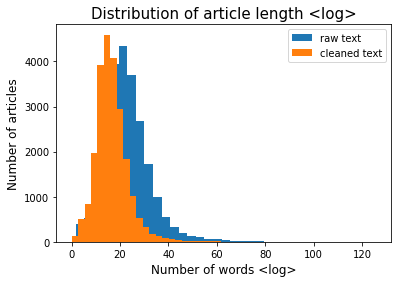

In [ ]:
plt.hist(np.sqrt(df_text_all['num_words']), label='raw text', bins=35)
plt.hist(np.sqrt(df_text_all['num_words_clean']), label='cleaned text', bins=35)
plt.legend()
plt.xlabel('Number of words <log>', size=12)
plt.ylabel('Number of articles', size=12)
plt.title('Distribution of article length <log>', size=15)
plt.show()

In [ ]:
vocab_list = []
for i in range(df_text_all.shape[0]):
    vocab_list += df_text_all['clean_text'].iloc[i].split()

len(set(vocab_list))

184774

In [ ]:
df_info_all.to_csv(INPUT_PATH + f'info_all_final.csv', index=False)
df_text_all.to_csv(INPUT_PATH + f'text_all_final.csv', index=False)

# 6.LDA model
In this project, we used Mallet for Topic modeling.

In [ ]:
df_info_all = pd.read_csv(INPUT_PATH + f'info_all_final.csv')
df_text_all = pd.read_csv(INPUT_PATH + f'text_all_final.csv')
print(df_info_all.head())

                                       uuid  ... noweek
0  5f6c36bc594a86b090826cf769558fc8a31aac8a  ...     11
1  9b265eb1f08a07a093f4e415f4878b5ccec71b0b  ...     11
2  0d49c01d17674d04754b87cb7c5167a589934e61  ...     11
3  ad1d5c62864864e9ae3d36b487cc322f5bcbaf9c  ...     11
4  9314d252503ee1f811c29627ab629c5b799ef103  ...     11

[5 rows x 23 columns]


In [ ]:
vocab_list = []
for i in range(df_text_all.shape[0]):
    vocab_list += df_text_all['clean_text'].iloc[i].split()

len(set(vocab_list))

184774

In [ ]:
c = Counter(vocab_list)

In [ ]:
vocab_list_model = []
for i in tqdm(range(df_text_all.shape[0])):
    temp_doc = df_text_all['clean_text'].iloc[i].split()
    token_list = [word for word in temp_doc if c[word] > 10]
    vocab_list_model.append(token_list)

In [ ]:
dictionary = corpora.Dictionary(vocab_list_model)
dictionary.filter_extremes(no_above=0.9)

In [ ]:
corpus = [dictionary.doc2bow(word) for word in vocab_list_model]

In [ ]:
print('vocab size: ', len(dictionary))

vocab size:  28703


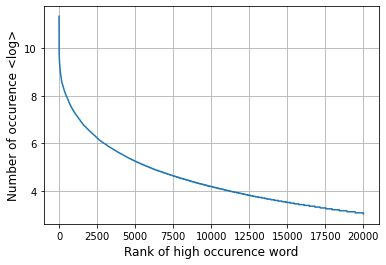

In [ ]:
num_list = []
for pair in c.most_common()[:20000]:
    num_list.append(np.log(pair[1]))

plt.plot(num_list)
plt.xlabel('Rank of high occurence word', size=12)
plt.ylabel('Number of occurence <log>', size=12)
plt.grid(True)

In [ ]:
c.most_common()[:10]

[('say', 84026),
 ('year', 33282),
 ('new', 33271),
 ('people', 30312),
 ('time', 26076),
 ('like', 22566),
 ('work', 21208),
 ('come', 19225),
 ('day', 18799),
 ('good', 18560)]

## (1).Decide the number of topics

In [ ]:
num_topic_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
perplexity_list = []
coherence_list = []
for num_topic in tqdm(num_topic_list):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                id2word=dictionary, 
                                                num_topics=num_topic,
                                                random_state=2021)
    perplexity_list.append(np.exp2(-lda_model.log_perplexity(corpus)))
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, 
                                                       texts=vocab_list_model, 
                                                       dictionary=dictionary, 
                                                       coherence='c_v')
    coherence_list.append(coherence_model_lda.get_coherence())

with open(INPUT_PATH + 'perplexity.pkl', 'wb') as f:
    pickle.dump(perplexity_list, f)

with open(INPUT_PATH + 'coherence.pkl', 'wb') as f:
    pickle.dump(coherence_list, f)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

FileNotFoundError: ignored

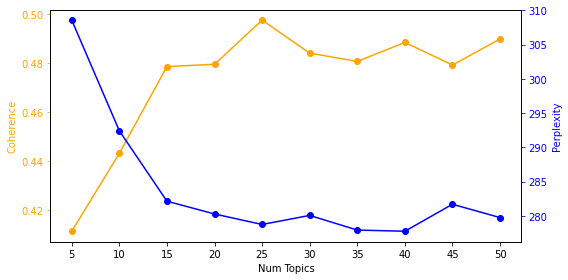

In [ ]:
# evaluation
fig, ax1 = plt.subplots(figsize=(8,4))

# coherence
c1 = 'orange'
ax1.plot(num_topic_list, coherence_list, 'o-', color=c1)
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence', color=c1); ax1.tick_params('y', colors=c1)

# perplexity
c2 = 'blue'
ax2 = ax1.twinx()
ax2.plot(num_topic_list, perplexity_list, 'o-', color=c2)
ax2.set_ylabel('Perplexity', color=c2); ax2.tick_params('y', colors=c2)

# Vis
ax1.set_xticks(num_topic_list)
fig.tight_layout()
plt.show()

In [ ]:
ldamallet = LdaMallet(mallet_path, corpus=corpus, 
                      num_topics=25, id2word=dictionary)

In [ ]:
gensimmodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
coherencemodel = gensim.models.CoherenceModel(model=gensimmodel, texts=vocab_list_model,
                                              dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())

0.6796603326618919


In [ ]:
ldamallet.show_topics(num_topics=25, formatted=False)

[(0,
  [('president', 0.022075260804769),
   ('trump', 0.020917606983180754),
   ('biden', 0.01895159144134554),
   ('state', 0.016995555673834362),
   ('house', 0.014247791143282947),
   ('vote', 0.01267098680008516),
   ('election', 0.008908611879923355),
   ('senate', 0.008512747498403236),
   ('white', 0.008336438152011922),
   ('bill', 0.008163455397061955)]),
 (1,
  [('film', 0.022585916643774344),
   ('series', 0.012897181779120795),
   ('star', 0.011266544104698913),
   ('movie', 0.01007614338341469),
   ('award', 0.009716910029654361),
   ('good', 0.009477421127147476),
   ('director', 0.007614338341468912),
   ('story', 0.007434721664588749),
   ('netflix', 0.0072727144658340905),
   ('actor', 0.0070191379808268)]),
 (2,
  [('company', 0.022252565552260458),
   ('market', 0.020079935710069483),
   ('year', 0.019461216246008547),
   ('share', 0.013754062568894767),
   ('stock', 0.012897100552580486),
   ('price', 0.012392168576162944),
   ('high', 0.010251541464871668),
   ('r

In [ ]:
with open(INPUT_PATH + 'malletmodel.pkl', 'wb') as f:
    pickle.dump(ldamallet, f)

In [ ]:
with open(INPUT_PATH + 'malletmodel.pkl', 'rb') as f:
    ldamallet = pickle.load(f)

In [ ]:
with open(INPUT_PATH + 'gensimmodel.pkl', 'wb') as f:
    pickle.dump(gensimmodel, f)

In [ ]:
with open(INPUT_PATH + 'gensimmodel.pkl', 'rb') as f:
    gensimmodel = pickle.load(f)

In [ ]:
len(dictionary)

28703

In [ ]:
vocab_matrix = np.zeros((df_text_all.shape[0], len(dictionary)))

In [ ]:
for idx in tqdm(range(df_text_all.shape[0])):
    for word_id, freq in corpus[idx]:
        vocab_matrix[idx][word_id] = freq

In [ ]:
lda_matrix = ldamallet.get_topics()
lda_matrix.shape

(25, 28703)

In [ ]:
test = vocab_matrix.dot(lda_matrix.T)
test.shape

(23280, 25)

In [ ]:
topic = test.argmax(axis=1)
topic.shape

(23280,)

In [ ]:
df_topic = pd.DataFrame(data={'uuid': df_info_all['uuid'],
                              'doc_topic': topic})
df_topic.head()

,uuid,doc_topic
0,5f6c36bc594a86b090826cf769558fc8a31aac8a,12
1,9b265eb1f08a07a093f4e415f4878b5ccec71b0b,14
2,0d49c01d17674d04754b87cb7c5167a589934e61,1
3,ad1d5c62864864e9ae3d36b487cc322f5bcbaf9c,5
4,9314d252503ee1f811c29627ab629c5b799ef103,1


In [ ]:
df_info_all = df_info_all.merge(df_topic, left_on='uuid', right_on='uuid')
df_info_all.head()

,uuid,author,country,published,image,site,site_category,page_view,fb_comment,fb_likes,fb_shares,linkedin,pinterest,url,date,year,month,day,weekday,hour,minute,seccont,noweek,doc_topic
0,5f6c36bc594a86b090826cf769558fc8a31aac8a,Alex Stedman,US,2021-03-15T01:59:00.000+02:00,1,www.yahoo.com,tech,5793.0,921,1166,1148,0,1,https://www.yahoo.com/entertainment/talk-cance...,2021-03-15 01:59:00,2021,3,15,Mon,1,59,6314340.0,11,12
1,9b265eb1f08a07a093f4e415f4878b5ccec71b0b,"David E. Sanger, Julian E. Barnes and Nicole P...",US,2021-03-15T01:58:58.000+02:00,0,www.msn.com,tech,578.0,17,28,107,0,1,https://www.msn.com/en-us/news/politics/white-...,2021-03-15 01:58:58,2021,3,15,Mon,1,58,6314338.0,11,14
2,0d49c01d17674d04754b87cb7c5167a589934e61,Marina Pitofsky,US,2021-03-15T01:58:57.000+02:00,0,www.msn.com,tech,578.0,396,3438,84,0,0,https://www.msn.com/en-us/news/politics/rachel...,2021-03-15 01:58:57,2021,3,15,Mon,1,58,6314337.0,11,1
3,ad1d5c62864864e9ae3d36b487cc322f5bcbaf9c,Kevin Rector,US,2021-03-15T01:51:00.000+02:00,1,www.latimes.com,tech,14.7,19,30,22,0,0,https://www.latimes.com/california/story/2021-...,2021-03-15 01:51:00,2021,3,15,Mon,1,51,6313860.0,11,5
4,9314d252503ee1f811c29627ab629c5b799ef103,Kim Lyons,US,2021-03-15T01:29:00.000+02:00,1,www.theverge.com,tech,31.9,0,17,25,0,1,https://www.theverge.com/2021/3/14/22326012/ne...,2021-03-15 01:29:00,2021,3,15,Mon,1,29,6312540.0,11,1


In [ ]:
df_info_all.to_csv(INPUT_PATH + 'info_all_model.csv', index=False)
df_text_all.to_csv(INPUT_PATH + 'text_all_model.csv', index=False)

In [ ]:
len(corpus)

23280

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of topic')

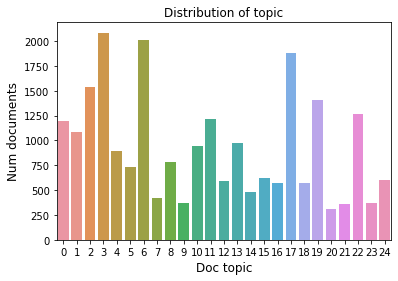

In [ ]:
sns.barplot(df_info_all['doc_topic'].value_counts().index, df_info_all['doc_topic'].value_counts())
plt.xlabel('Doc topic', size=12)
plt.ylabel('Num documents', size=12)
plt.title('Distribution of topic', size=12)

In [ ]:
df_info_all['site'].value_counts().iloc[:19]

www.telegraph.co.uk      1244
variety.com               985
phys.org                  922
www.stuff.co.nz           774
www.msn.com               683
globalnews.ca             657
www.wsj.com               595
www.marketwatch.com       537
www.cnbc.com              481
www.ndtv.com              460
www.autoevolution.com     366
zeenews.india.com         363
finance.yahoo.com         355
gulfnews.com              352
www.yahoo.com             351
www.cnet.com              321
www.nbcsports.com         310
www.news24.com            274
www.standard.co.uk        274
Name: site, dtype: int64

# 7.Create predict model

In [ ]:
INPUT_PATH = 'input/'

In [ ]:
df_info_all = pd.read_csv(INPUT_PATH + 'info_all_model.csv')
df_text_all = pd.read_csv(INPUT_PATH + 'text_all_model.csv')

In [ ]:
df_info_all['country'].value_counts()

US     14908
GB      2388
IN       962
NZ       943
UNK      616
CA       605
SG       410
AE       349
IE       336
CN       300
AU       223
JP       203
PH       185
FR       167
ZA       157
NG       127
ES       123
DE        35
GR        34
NL        30
ID        28
TH        28
IT        27
HK        19
RU        13
MY        12
IR         9
CH         9
EU         7
IL         4
CO         3
ME         2
BR         2
LU         2
IO         2
PK         2
BG         2
BE         2
TR         1
KR         1
TW         1
LT         1
EG         1
KE         1
Name: country, dtype: int64

In [ ]:
df_info_all['site'].value_counts()[:5]

www.telegraph.co.uk    1244
variety.com             985
phys.org                922
www.stuff.co.nz         774
www.msn.com             683
Name: site, dtype: int64

In [ ]:
def count_words(text):
    word_list = text.split()
    return len(word_list)

In [ ]:
df_text_all['num_title_words'] = df_text_all['title'].map(lambda x: count_words(x))

In [ ]:
df_info_all['fb_shares'].describe()

count    23280.000000
mean       121.222895
std        670.667261
min          4.000000
25%         12.000000
50%         22.000000
75%         60.000000
max      49807.000000
Name: fb_shares, dtype: float64

In [ ]:
df_info_all['log_share'] = df_info_all['fb_shares'].map(lambda x: np.log(1 + x))
df_info_all['log_share'].describe()

count    23280.000000
mean         3.471231
std          1.266361
min          1.609438
25%          2.564949
50%          3.135494
75%          4.110874
max         10.815931
Name: log_share, dtype: float64

Text(0, 0.5, 'Log number of news')

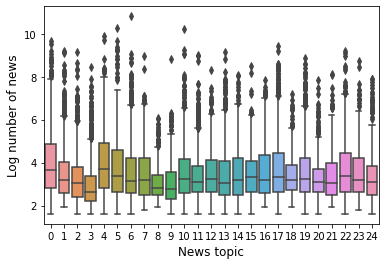

In [ ]:
sns.boxplot(x='doc_topic', y='log_share', data=df_info_all)
plt.xlabel('News topic', size=12)
plt.ylabel('Log number of news', size=12)

## (1).Create dataset for the model

In [ ]:
df_info_all = df_info_all.merge(df_text_all[['uuid', 'num_title_words', 'num_words', 'num_words_clean']], 
                                left_on='uuid', right_on='uuid')
df_info_all.head()

,uuid,author,country,published,image,site,site_category,page_view,fb_comment,fb_likes,fb_shares,linkedin,pinterest,url,date,year,month,day,weekday,hour,minute,seccont,noweek,doc_topic,log_share,num_title_words,num_words,num_words_clean
0,5f6c36bc594a86b090826cf769558fc8a31aac8a,Alex Stedman,US,2021-03-15T01:59:00.000+02:00,1,www.yahoo.com,tech,5793.0,921,1166,1148,0,1,https://www.yahoo.com/entertainment/talk-cance...,2021-03-15 01:59:00,2021,3,15,Mon,1,59,6314340.0,11,12,7.046647,10,499,242
1,9b265eb1f08a07a093f4e415f4878b5ccec71b0b,"David E. Sanger, Julian E. Barnes and Nicole P...",US,2021-03-15T01:58:58.000+02:00,0,www.msn.com,tech,578.0,17,28,107,0,1,https://www.msn.com/en-us/news/politics/white-...,2021-03-15 01:58:58,2021,3,15,Mon,1,58,6314338.0,11,14,4.682131,11,54,26
2,0d49c01d17674d04754b87cb7c5167a589934e61,Marina Pitofsky,US,2021-03-15T01:58:57.000+02:00,0,www.msn.com,tech,578.0,396,3438,84,0,0,https://www.msn.com/en-us/news/politics/rachel...,2021-03-15 01:58:57,2021,3,15,Mon,1,58,6314337.0,11,1,4.442651,10,310,177
3,ad1d5c62864864e9ae3d36b487cc322f5bcbaf9c,Kevin Rector,US,2021-03-15T01:51:00.000+02:00,1,www.latimes.com,tech,14.7,19,30,22,0,0,https://www.latimes.com/california/story/2021-...,2021-03-15 01:51:00,2021,3,15,Mon,1,51,6313860.0,11,5,3.135494,12,196,104
4,9314d252503ee1f811c29627ab629c5b799ef103,Kim Lyons,US,2021-03-15T01:29:00.000+02:00,1,www.theverge.com,tech,31.9,0,17,25,0,1,https://www.theverge.com/2021/3/14/22326012/ne...,2021-03-15 01:29:00,2021,3,15,Mon,1,29,6312540.0,11,1,3.258097,14,415,182


In [ ]:
df_info_all.shape

(23280, 28)

Remove the data has more than 5 of log_share (outlier)

In [ ]:
df_info_all_v2 = df_info_all[df_info_all['log_share'] < 5].reset_index(drop=True)

In [ ]:
country_list = list(df_info_all_v2['country'].value_counts().index[:10])
country_list

['US', 'GB', 'IN', 'NZ', 'UNK', 'CA', 'AE', 'SG', 'IE', 'CN']

In [ ]:
site_list = list(df_info_all_v2['site'].value_counts().index[:15])
site_list

['www.telegraph.co.uk',
 'variety.com',
 'phys.org',
 'www.stuff.co.nz',
 'www.msn.com',
 'globalnews.ca',
 'www.marketwatch.com',
 'www.ndtv.com',
 'www.wsj.com',
 'zeenews.india.com',
 'www.autoevolution.com',
 'gulfnews.com',
 'www.cnbc.com',
 'finance.yahoo.com',
 'www.nbcsports.com']

In [ ]:
df_info_all_v2['country_model'] = df_info_all_v2['country'].map(lambda x: x if x in country_list else 'other')
df_info_all_v2['site_model'] = df_info_all_v2['site'].map(lambda x: x if x in site_list else 'other')

In [ ]:
country_encoder = LabelEncoder()
site_encoder = LabelEncoder()

df_info_all_v2['country_label'] = country_encoder.fit_transform(df_info_all_v2['country_model'])
df_info_all_v2['site_label'] = site_encoder.fit_transform(df_info_all_v2['site_model'])

df_info_all_v2['log_page'] = df_info_all_v2['page_view'].map(lambda x: np.log(1 + x))

In [ ]:
df_info_all_v2.columns

Index(['uuid', 'author', 'country', 'published', 'image', 'site',
       'site_category', 'page_view', 'fb_comment', 'fb_likes', 'fb_shares',
       'linkedin', 'pinterest', 'url', 'date', 'year', 'month', 'day',
       'weekday', 'hour', 'minute', 'seccont', 'noweek', 'doc_topic',
       'log_share', 'num_title_words', 'num_words', 'num_words_clean',
       'country_model', 'site_model', 'country_label', 'site_label',
       'log_page'],
      dtype='object')

## (2).Baseline model

In [ ]:
col = ['log_share','image', 
       'log_page', 'fb_comment', 'fb_likes', 
       'doc_topic', 'num_title_words', 'num_words', 
       'num_words_clean', 'country_label', 'site_label']
df_info_model = df_info_all_v2[col]
df_info_model.head()

,log_share,image,log_page,fb_comment,fb_likes,doc_topic,num_title_words,num_words,num_words_clean,country_label,site_label
0,4.682131,0,6.361302,17,28,14,11,54,26,9,9
1,4.442651,0,6.361302,396,3438,1,10,310,177,9,9
2,3.135494,1,2.753661,19,30,5,12,196,104,9,3
3,3.258097,1,3.493473,0,17,1,14,415,182,9,3
4,2.484907,0,6.361302,0,5,6,16,2262,937,9,9


In [ ]:
RANDOM_SEED = 42
df_train, df_test = train_test_split(
    df_info_model,
    test_size=0.2,
    random_state=RANDOM_SEED
    )
df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
    )

In [ ]:
col_x = ['image', 
         'log_page', 'fb_comment', 'fb_likes', 
         'doc_topic', 'num_title_words', 'num_words', 
         'num_words_clean', 'country_label', 'site_label']

In [ ]:
cate_features = ['image', 'doc_topic', 'country_label', 'site_label']
train_data = lgb.Dataset(data=df_train[col_x], label=df_train['log_share'],
                         categorical_feature=cate_features, free_raw_data=False)
valid_data = lgb.Dataset(data=df_val[col_x], label=df_val['log_share'],
                         categorical_feature=cate_features, reference=train_data, 
                        free_raw_data=False)
test_data = lgb.Dataset(data=df_test[col_x], label=df_test['log_share'],
                         categorical_feature=cate_features, reference=train_data, 
                        free_raw_data=False)

In [ ]:
lgbm_params = {
    'boosting': 'gbdt', 
    'application': 'regression', 
    'learning_rate': 0.02,
    'num_leaves': 41,
    'metric': 'rmse',
    'random_seed': 2021,
              }

In [ ]:
evaluation_results = {}
clf = lgb.train(train_set=train_data,
                params=lgbm_params,
                valid_sets=[train_data, valid_data, test_data], 
                valid_names=['Train', 'Valid', 'Test'],
                evals_result=evaluation_results,
                num_boost_round=300,
                early_stopping_rounds=50,
                verbose_eval=20
                )
optimum_boost_rounds = clf.best_iteration

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[20]	Train's rmse: 0.686455	Valid's rmse: 0.698341	Test's rmse: 0.678677
[40]	Train's rmse: 0.617674	Valid's rmse: 0.632775	Test's rmse: 0.613241
[60]	Train's rmse: 0.57708	Valid's rmse: 0.594341	Test's rmse: 0.575862
[80]	Train's rmse: 0.552031	Valid's rmse: 0.571228	Test's rmse: 0.553183
[100]	Train's rmse: 0.535876	Valid's rmse: 0.557281	Test's rmse: 0.539809
[120]	Train's rmse: 0.524501	Valid's rmse: 0.54769	Test's rmse: 0.531381
[140]	Train's rmse: 0.515971	Valid's rmse: 0.540877	Test's rmse: 0.525901
[160]	Train's rmse: 0.508819	Valid's rmse: 0.53588	Test's rmse: 0.521784
[180]	Train's rmse: 0.502792	Valid's rmse: 0.532003	Test's rmse: 0.518649
[200]	Train's rmse: 0.497081	Valid's rmse: 0.528342	Test's rmse: 0.516321
[220]	Train's rmse: 0.492292	Valid's rmse: 0.526202	Test's rmse: 0.514767
[240]	Train's rmse: 0.488003	Valid's rmse: 0.524707	Test's rmse: 0.513517
[260]	Train's rmse: 0.484435	Valid's rmse: 0.523534	Test'

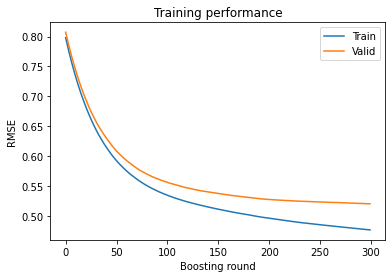

In [ ]:
plt.plot(evaluation_results['Train']['rmse'], label='Train')
plt.plot(evaluation_results['Valid']['rmse'], label='Valid')
plt.ylabel('RMSE')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()

In [ ]:
def plot_feature_importance(df): 
    n_features = len(df)
    df_plot = df.sort_values('importance')
    f_importance_plot = df_plot['importance'].values
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values
    plt.yticks(np.arange(n_features), cols_plot)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [ ]:
cols = list(df_info_model.drop('log_share',axis=1).columns)
f_importance = np.array(clf.feature_importance(importance_type='gain'))
f_importance = f_importance / np.sum(f_importance)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False)
display(df_importance)

,feature,importance
2,fb_comment,0.381134
3,fb_likes,0.258231
1,log_page,0.117836
4,doc_topic,0.115122
8,country_label,0.043750
9,site_label,0.036673
7,num_words_clean,0.017275
6,num_words,0.017052
5,num_title_words,0.011467
0,image,0.001461


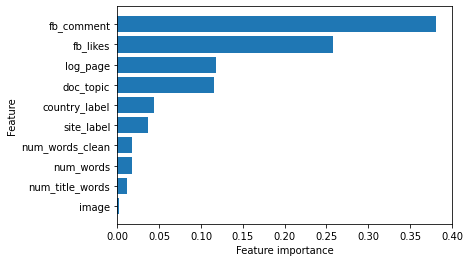

In [ ]:
plot_feature_importance(df_importance)

## (3).General model

In [ ]:
col_x = ['image', 
         'log_page', 
         'doc_topic', 'num_title_words', 
         'num_words_clean', 'country_label', 'site_label']

In [ ]:
cate_features = ['image', 'doc_topic', 'country_label', 'site_label']
train_data = lgb.Dataset(data=df_train[col_x], label=df_train['log_share'],
                         categorical_feature=cate_features, free_raw_data=False)
valid_data = lgb.Dataset(data=df_val[col_x], label=df_val['log_share'],
                         categorical_feature=cate_features, reference=train_data, 
                        free_raw_data=False)
test_data = lgb.Dataset(data=df_test[col_x], label=df_test['log_share'],
                         categorical_feature=cate_features, reference=train_data, 
                        free_raw_data=False)

In [ ]:
evaluation_results = {}
clf = lgb.train(train_set=train_data,
                params=lgbm_params,
                valid_sets=[train_data, valid_data, test_data], 
                valid_names=['Train', 'Valid', 'Test'],
                evals_result=evaluation_results,
                num_boost_round=300,
                early_stopping_rounds=50,
                verbose_eval=20
                )
optimum_boost_rounds = clf.best_iteration

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[20]	Train's rmse: 0.774781	Valid's rmse: 0.789483	Test's rmse: 0.7642
[40]	Train's rmse: 0.7575	Valid's rmse: 0.777144	Test's rmse: 0.750533
[60]	Train's rmse: 0.745948	Valid's rmse: 0.769445	Test's rmse: 0.742102
[80]	Train's rmse: 0.737626	Valid's rmse: 0.76484	Test's rmse: 0.736827
[100]	Train's rmse: 0.731054	Valid's rmse: 0.761194	Test's rmse: 0.733949
[120]	Train's rmse: 0.725479	Valid's rmse: 0.759341	Test's rmse: 0.732748
[140]	Train's rmse: 0.720791	Valid's rmse: 0.758226	Test's rmse: 0.731766
[160]	Train's rmse: 0.716502	Valid's rmse: 0.757237	Test's rmse: 0.730893
[180]	Train's rmse: 0.712638	Valid's rmse: 0.756864	Test's rmse: 0.730353
[200]	Train's rmse: 0.708968	Valid's rmse: 0.756231	Test's rmse: 0.729867
[220]	Train's rmse: 0.705959	Valid's rmse: 0.756225	Test's rmse: 0.729737
[240]	Train's rmse: 0.70321	Valid's rmse: 0.755959	Test's rmse: 0.729846
[260]	Train's rmse: 0.700344	Valid's rmse: 0.755645	Test's r

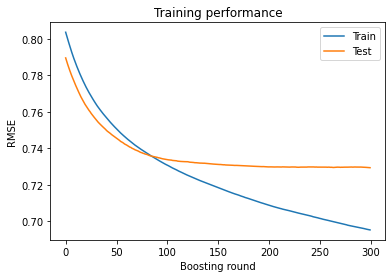

In [ ]:
plt.plot(evaluation_results['Train']['rmse'], label='Train')
plt.plot(evaluation_results['Test']['rmse'], label='Test')
plt.ylabel('RMSE')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()

In [ ]:
cols = list(df_info_model.drop(['log_share', 'fb_comment', 'fb_likes', 'num_words'] ,axis=1).columns)
f_importance = np.array(clf.feature_importance(importance_type='gain'))
f_importance = f_importance / np.sum(f_importance)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False)
display(df_importance)

,feature,importance
1,log_page,0.282320
2,doc_topic,0.225426
4,num_words_clean,0.156745
5,country_label,0.139546
6,site_label,0.113413
3,num_title_words,0.075168
0,image,0.007382


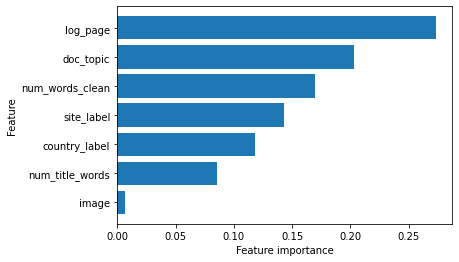

In [ ]:
plot_feature_importance(df_importance)

## (4).Add sentive analysis
You should run the below code on GPU

In [ ]:
!pip install transformers -q

In [ ]:
from transformers import pipeline

In [ ]:
sentiment_analysis = pipeline("sentiment-analysis", 
                              return_all_scores=True)

In [ ]:
positive_list = []
for i in tqdm(range(df_info_all_v2.shape[0])):
    negative_list.append(sentiment_analysis(df_info_all_v2['clean_text'].iloc[i][:1000])[0][0]['score'])

In [ ]:
df_info_all_v2['positive'] = positive_list

In [ ]:
df_info_all_v2.head(2)

,uuid,author,country,published,image,site,site_category,page_view,fb_comment,fb_likes,fb_shares,linkedin,pinterest,url,date,year,month,day,weekday,hour,minute,seccont,noweek,doc_topic,log_share,num_title_words,num_words,num_words_clean,country_model,site_model,country_label,site_label,log_page
0,9b265eb1f08a07a093f4e415f4878b5ccec71b0b,"David E. Sanger, Julian E. Barnes and Nicole P...",US,2021-03-15T01:58:58.000+02:00,0,www.msn.com,tech,578.0,17,28,107,0,1,https://www.msn.com/en-us/news/politics/white-...,2021-03-15 01:58:58,2021,3,15,Mon,1,58,6314338.0,11,14,4.682131,11,54,26,US,www.msn.com,9,9,6.361302
1,0d49c01d17674d04754b87cb7c5167a589934e61,Marina Pitofsky,US,2021-03-15T01:58:57.000+02:00,0,www.msn.com,tech,578.0,396,3438,84,0,0,https://www.msn.com/en-us/news/politics/rachel...,2021-03-15 01:58:57,2021,3,15,Mon,1,58,6314337.0,11,1,4.442651,10,310,177,US,www.msn.com,9,9,6.361302


In [ ]:
df_info_all_v2.to_csv(INPUT_PATH + 'df_all_final.csv', index=False)

## (5).Prediction model with sentiment

In [ ]:
df_info_all_v2 = pd.read_csv(INPUT_PATH + 'df_all_final.csv')

In [ ]:
col = ['log_share','image', 
       'log_page', 'fb_comment', 'fb_likes', 
       'doc_topic', 'num_title_words', 'num_words', 
       'num_words_clean', 'country_label', 
       'site_label', 'positive']
df_info_model = df_info_all_v2[col]
df_train, df_test = train_test_split(
    df_info_model,
    test_size=0.2,
    random_state=RANDOM_SEED
    )
df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
    )

In [ ]:
col_x = ['image', 
         'log_page', 'doc_topic', 'num_title_words', 
         'num_words_clean', 'country_label', 
         'site_label', 'positive']

In [ ]:
cate_features = ['image', 'doc_topic', 'country_label', 'site_label']
train_data = lgb.Dataset(data=df_train[col_x], label=df_train['log_share'],
                         categorical_feature=cate_features, free_raw_data=False)
valid_data = lgb.Dataset(data=df_val[col_x], label=df_val['log_share'],
                         categorical_feature=cate_features, reference=train_data, 
                        free_raw_data=False)
test_data = lgb.Dataset(data=df_test[col_x], label=df_test['log_share'],
                         categorical_feature=cate_features, reference=train_data, 
                        free_raw_data=False)

In [ ]:
evaluation_results = {}
clf = lgb.train(train_set=train_data,
                params=lgbm_params,
                valid_sets=[train_data, valid_data, test_data], 
                valid_names=['Train', 'Valid', 'Test'],
                evals_result=evaluation_results,
                num_boost_round=300,
                early_stopping_rounds=50,
                verbose_eval=20
                )
optimum_boost_rounds = clf.best_iteration

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[20]	Train's rmse: 0.774794	Valid's rmse: 0.7897	Test's rmse: 0.764339
[40]	Train's rmse: 0.756977	Valid's rmse: 0.776485	Test's rmse: 0.750082
[60]	Train's rmse: 0.744993	Valid's rmse: 0.767956	Test's rmse: 0.741652
[80]	Train's rmse: 0.736179	Valid's rmse: 0.762499	Test's rmse: 0.736311
[100]	Train's rmse: 0.729376	Valid's rmse: 0.758879	Test's rmse: 0.733998
[120]	Train's rmse: 0.723208	Valid's rmse: 0.756655	Test's rmse: 0.732421
[140]	Train's rmse: 0.718079	Valid's rmse: 0.755146	Test's rmse: 0.731096
[160]	Train's rmse: 0.713377	Valid's rmse: 0.754276	Test's rmse: 0.730423
[180]	Train's rmse: 0.709216	Valid's rmse: 0.754136	Test's rmse: 0.729847
[200]	Train's rmse: 0.705377	Valid's rmse: 0.753649	Test's rmse: 0.729301
[220]	Train's rmse: 0.701744	Valid's rmse: 0.75325	Test's rmse: 0.729071
[240]	Train's rmse: 0.69824	Valid's rmse: 0.752846	Test's rmse: 0.728965
[260]	Train's rmse: 0.694636	Valid's rmse: 0.752319	Test's

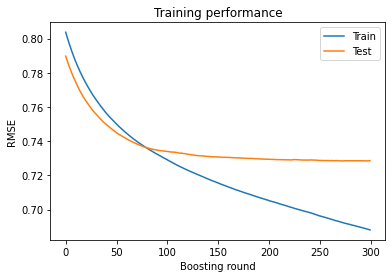

In [ ]:
plt.plot(evaluation_results['Train']['rmse'], label='Train')
plt.plot(evaluation_results['Test']['rmse'], label='Test')
plt.ylabel('RMSE')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()

In [ ]:
cols = list(df_info_model.drop(['log_share', 'fb_comment', 'fb_likes', 'num_words'] ,axis=1).columns)
f_importance = np.array(clf.feature_importance(importance_type='gain'))
f_importance = f_importance / np.sum(f_importance)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False)
display(df_importance)

,feature,importance
1,log_page,0.245591
2,doc_topic,0.206508
5,country_label,0.133884
4,num_words_clean,0.127302
6,site_label,0.114553
7,positive,0.107008
3,num_title_words,0.061822
0,image,0.003333


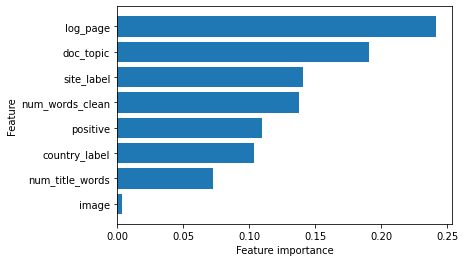

In [ ]:
plot_feature_importance(df_importance)

# 8.Transformers + Neural Net model

Please see SI630_project_code_2.ipynb